In [1]:
import os, sys, copy
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from modules.DataSchemas import ScoreSchema
from modules.Interproc import GuiviewState
from modules.Interproc import DBInterface
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.AnalysisHelpers import (applyTracker
                                    ,multiPlot
                                    ,roiSelectZoomWindow
                                    )
from modules.SearchParams import (buildGradient, combineGradients)
from modules.EvalHelpers import EvalTracker

### Load data & Validate

In [3]:
db = DBInterface("../data/misc/books/search-params-1/data.db")

listGS = [pickle.loads(record[1]) for record in db.selectAll()]

In [4]:
print [_gs.frameCounter for _gs in listGS]
print [_gs.zoomRect for _gs in listGS]

[0, 189, 312]
[(192.0, 150.0, 66.0, 68.0), (283.0, 419.0, 22.0, 22.0), (222.0, 262.0, 20.0, 22.0)]


### Build Gradient and ParamSpace

In [5]:
baseTracker = TrackFactory(on=True)
baseTracker.setInit(ballColor="green")
baseTracker.setAlgoEnum(1)

In [6]:
varName = 'thresh_lo'
g_thresh_lo = buildGradient( 
               name=varName
              ,baseline= baseTracker.getTrackParams()[varName]
              ,index = 1
              ,validMin = 0
              ,validMax = 255
             )

varName = 'repair_iterations'
g_repair_iterations = buildGradient( 
               name=varName
              ,baseline= baseTracker.getTrackParams()[varName]
              ,delta = 1
              ,steps = 2
              ,validMin = 0
              ,validMax = 20
             )

list_gradients = [g_thresh_lo, g_repair_iterations]

paramSpace = combineGradients(list_gradients)

In [7]:
print 'paramSpace len: %s' % str(len(paramSpace))
print "\n".join([str(x) for x in paramSpace[:5]])

paramSpace len: 44
{'thresh_lo': (29, 61, 6), 'repair_iterations': 0}
{'thresh_lo': (29, 61, 6), 'repair_iterations': 1}
{'thresh_lo': (29, 61, 6), 'repair_iterations': 2}
{'thresh_lo': (29, 61, 6), 'repair_iterations': 3}
{'thresh_lo': (29, 66, 6), 'repair_iterations': 0}


### Play with EvalTracker 

In [8]:
ev = EvalTracker()

In [9]:
#estimate obj from plts
handObj = listGS[1].zoomRect
obj = (handObj[0] + 5, handObj[1] + 1, 11, 11)
handScore = ScoreSchema()
handScore.addCircle(obj)
score = handScore.getAll()
score

{'0': {'data': (288.0, 420.0, 11, 11), 'type': 'circle'}}

In [10]:
#set baseline score for paramLoop
ev = EvalTracker()
ev.setBaselineScore(score)
ev.baselineScore

{'0': {'data': (288.0, 420.0, 11, 11), 'type': 'circle'}}

In [11]:
# generate some other score data
baseTracker.setInit(ballColor="green")
outputData = applyTracker(listGS, baseTracker, bLogPlts=False)
score1 = outputData['listScore'][1]
score2 = outputData['listScore'][0]
score1, score2

(None, {'0': {'data': (209, 168, 35, 35), 'type': 'circle'}})

In [12]:
#make sure methods in evalTracker work
print ev.checkTrackSuccess(score1)
print ev.checkTrackSuccess(score2)

False
True


In [13]:
print ev.distanceFromBaseline(score1)
print ev.distanceFromBaseline(score2)

9999.9
249.17664417


In [14]:
print ev.checkTrackInsideBaseline(score1)
print ev.checkTrackInsideBaseline(score2)

score3 = copy.deepcopy(score)
score3['0']['data'] = (290.0, 421.0, 5, 5) #demo data
print ev.checkTrackInsideBaseline(score3)

False
False
True


### Apply Tracker(Params) to all points in ParamSpace

In [15]:
#Question - what is smallest change in params
# plt the params that work vs don't work on a scatter plot plane

In [16]:
loopLog = []
i = 0

targetGS = [listGS[1]]

for paramPoint in paramSpace:
    
    iterLog = {}
    
    iterLog['i'] = i
    i += 1
    
    baseTracker.setTrackParams(**paramPoint)
    
    iterLog['track_params'] = baseTracker.getTrackParams()
    
    outcomeData = applyTracker(targetGS, baseTracker, bLogPlts=False)
    
    #TODO - allow list for score
    score = outcomeData['listScore'][0]
    
    evalDict = {}
    evalDict['distance'] = ev.distanceFromBaseline(score)
    evalDict['success'] = ev.checkTrackSuccess(score)
    evalDict['inBaseline'] = ev.checkTrackInsideBaseline(score)
    #evalDict['inWindow'] = ev.checkTrackInWindow(score)
    iterLog['eval'] = evalDict
    
    loopLog.append(iterLog)

### Investigate ParamPoints that had some type of success

In [17]:
goodParams = filter(lambda elem: elem['eval']['success'] , loopLog)
print len(goodParams)

18


In [18]:
goodParams = filter(lambda elem: elem['eval']['inBaseline'] , loopLog)
print len(goodParams)

# what are the parameters that worked?
# they are high thresh_lo vals with low repairIters
inputParams = [x['track_params'] for x in goodParams]
inputParams

2


[{'repair_iterations': 0,
  'thresh_hi': (64, 255, 255),
  'thresh_lo': (29, 96, 6),
  'tracking_blur': 1},
 {'repair_iterations': 0,
  'thresh_hi': (64, 255, 255),
  'thresh_lo': (29, 101, 6),
  'tracking_blur': 1}]

In [19]:
gradient_dict = {}

varName = 'thresh_lo'
gradient_dict[varName] = [d[varName] for d in g_thresh_lo]

varName = 'repair_iterations'
gradient_dict[varName] = [d[varName] for d in g_repair_iterations]

gradient_dict

{'repair_iterations': [0, 1, 2, 3],
 'thresh_lo': [(29, 61, 6),
  (29, 66, 6),
  (29, 71, 6),
  (29, 76, 6),
  (29, 81, 6),
  (29, 86, 6),
  (29, 91, 6),
  (29, 96, 6),
  (29, 101, 6),
  (29, 106, 6),
  (29, 111, 6)]}

### Plot 2-D ParamSpace and show what points worked

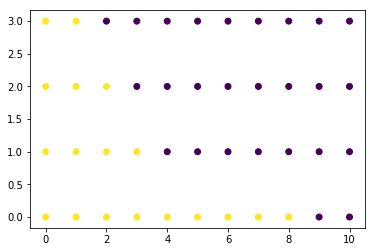

In [20]:
#2 entries: x - 1st entry; y 2 entry
axis_keys = ['thresh_lo', 'repair_iterations']

x, y, c = [], [], []

for iterPoint in loopLog:
    
    _params = iterPoint['track_params']
    
    for _paramKey in axis_keys:
    
        ind = gradient_dict[_paramKey].index(_params[_paramKey])
        
        if axis_keys.index(_paramKey) == 0:
            x.append(ind)
        else:
            y.append(ind)
            
    outcome = int(iterPoint['eval']['success'])

    c.append(outcome)
    
plt.scatter(x, y, c=c)

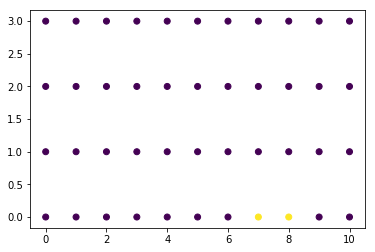

In [21]:
#2 entries: x - 1st entry; y 2 entry
axis_keys = ['thresh_lo', 'repair_iterations']

x, y, c = [], [], []

for iterPoint in loopLog:
    
    _params = iterPoint['track_params']
    
    for _paramKey in axis_keys:
    
        ind = gradient_dict[_paramKey].index(_params[_paramKey])
        
        if axis_keys.index(_paramKey) == 0:
            x.append(ind)
        else:
            y.append(ind)
            
    outcome = int(iterPoint['eval']['inBaseline'])

    c.append(outcome)
    
plt.scatter(x, y, c=c)

### Investigate Transforms on succesful params

c:\python27\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


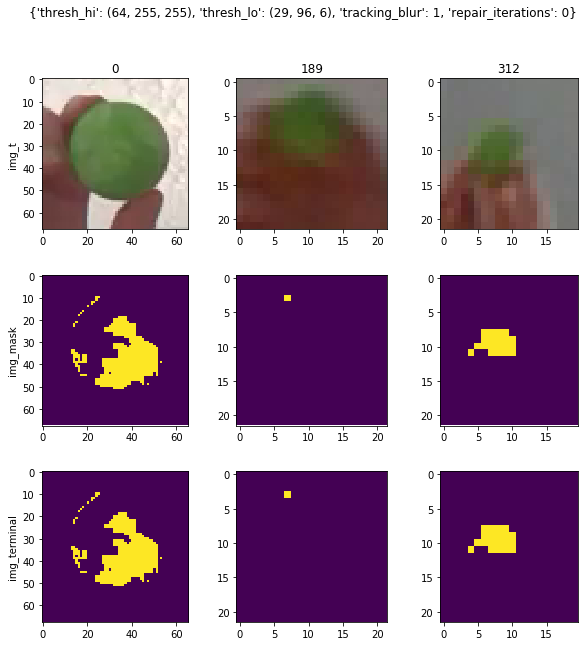

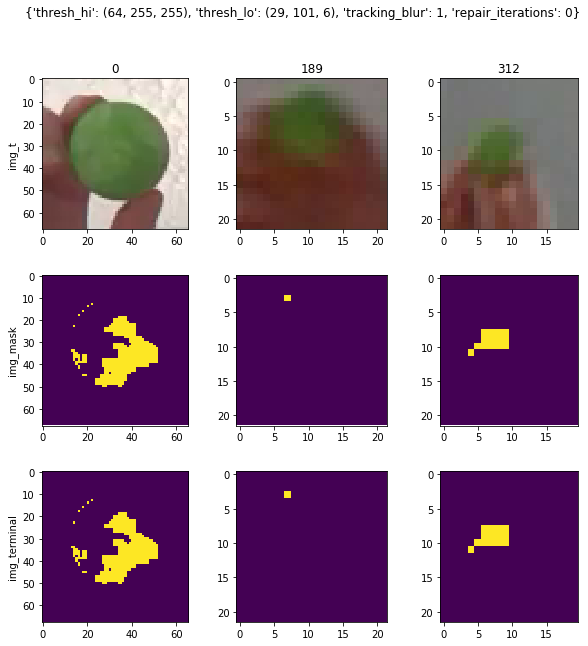

In [22]:
# what do the transforms looks like that worked?

inputParams = [point['track_params'] for point in goodParams]

for _inputParam in inputParams:
    
    tracker = TrackFactory(on=True)
    tracker.setAlgoEnum(1)
    tracker.setTrackParams(**_inputParam)
    
    data = applyTracker(listGS, tracker, roiSelectZoomWindow)

    multiPlot( list_list_imgs = data['listPlts']
              ,input_frame_titles = data['listFrameTitles']
              ,input_transform_titles = data['listTransformTitles']
              ,input_figure_title = str(tracker.getTrackParams())
             )